# Time series analysis

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data preparation

In [2]:
ts_data=joblib.load('C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\data\\cleaned_superstore_data.csv')

In [3]:
monthly_sales=ts_data.groupby(pd.Grouper(key='Order Date',freq='M'))['Sales'].sum().reset_index()

C:\Users\CSC\AppData\Local\Temp\ipykernel_4352\1995819166.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales=ts_data.groupby(pd.Grouper(key='Order Date',freq='M'))['Sales'].sum().reset_index()


In [4]:
monthly_sales.rename(columns={'Order Date':'date'},inplace=True)
monthly_sales.set_index('date',inplace=True)
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


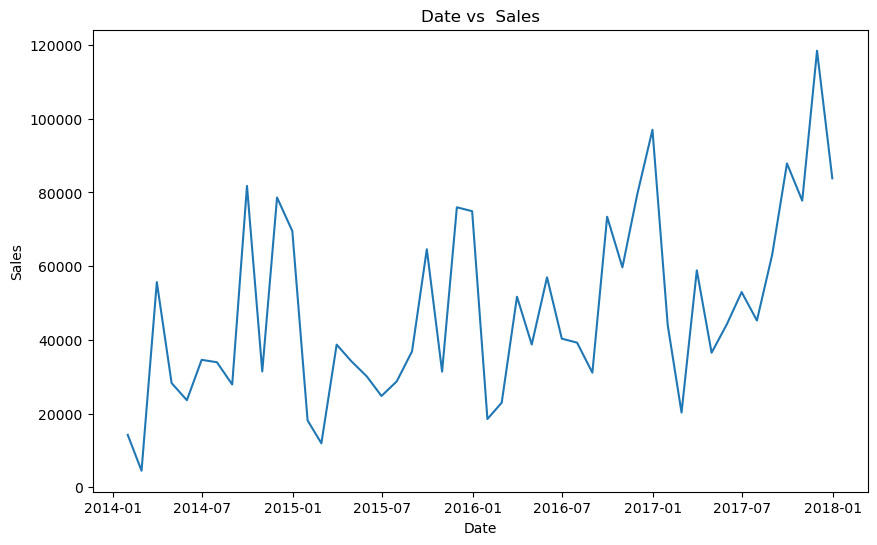

In [5]:
plt.figure(figsize=(10,6))

plt.plot(monthly_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Date vs  Sales')
plt.show()

### Decomposition and stationarity check

Figure(640x480)


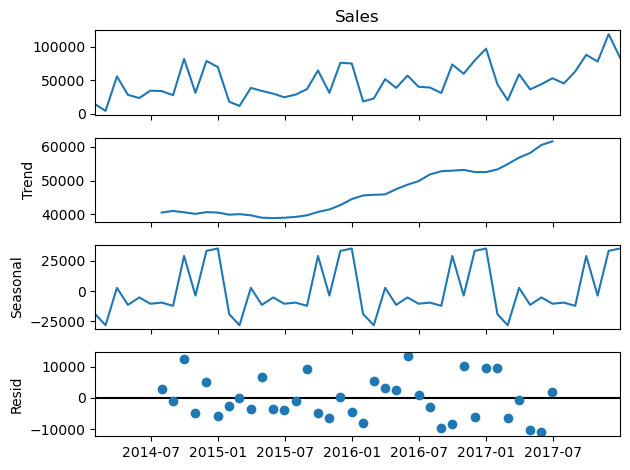

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(monthly_sales['Sales'])
print(decompose.plot())

In [7]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(monthly_sales['Sales'])
p_val=result[1]

if p_val<0.05:
    print('Null hypothesis rejected, data is stationary')
else:
    print('Null hypothesis accepted, data is not stationary')

Null hypothesis rejected, data is stationary


Axes(0.125,0.11;0.775x0.77)


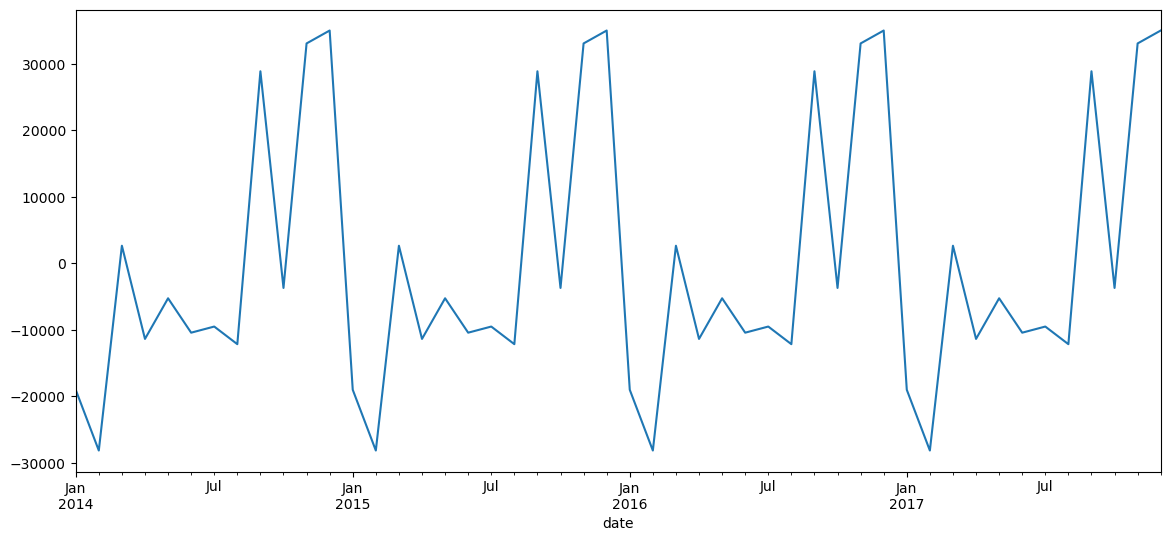

In [8]:
plt.figure(figsize=(14,6))
print(decompose.seasonal.plot())

## SARIMAX Model

In [75]:
# to find the best (p,d,q) and (P,D,Q,s)

import itertools
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)

P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
s=[12]

order=list(itertools.product(p,d,q))
s_order=list(itertools.product(P,D,Q,s))

train=monthly_sales.iloc[:-6,:]
test=monthly_sales.iloc[-6:,:]

results=[]

for i in order:
    for j in s_order:
        try:
            model=SARIMAX(train['Sales'],order=i,seasonal_order=j)
            model_fit=model.fit()
            pred=model_fit.predict(start=len(train),end=len(train)+len(test)-1)
            error=np.sqrt(mean_squared_error(test['Sales'],pred))
            mae=mean_absolute_error(test['Sales'],pred)
            mape=np.mean(np.abs((test['Sales']-pred)/test['Sales']))*100
            results.append({'Order':i,
                            'Seasonal Order':j,
                            'RMSE':error,
                            'MAE':mae,
                            'MAPE':mape,
                            'AIC':model_fit.aic,
                            'BIC':model_fit.bic
                           })
        except:
            continue

sarimax_metrics=pd.DataFrame(results)
best = sarimax_metrics.sort_values(by='RMSE',ascending=True).iloc[0]
print(f"Best SARIMA Model: Order={best['Order']}, Seasonal_Order={best['Seasonal Order']}, RMSE={best['RMSE']:.2f}")

C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  

Best SARIMA Model: Order=(3, 1, 3), Seasonal_Order=(1, 1, 0, 12), RMSE=12396.19


C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
file_name='sarimax_metrics.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(sarimax_metrics,abs_path)

['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\sarimax_metrics.joblib']

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(monthly_sales['Sales'],order=(3,1,3),seasonal_order=(1,1,0,12))
model_fit=model.fit()

C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\CSC\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [83]:
file_name='sarimax_model.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(model,abs_path)

['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\sarimax_model.joblib']

In [11]:
sarimax_forecast=model_fit.forecast(steps=36)

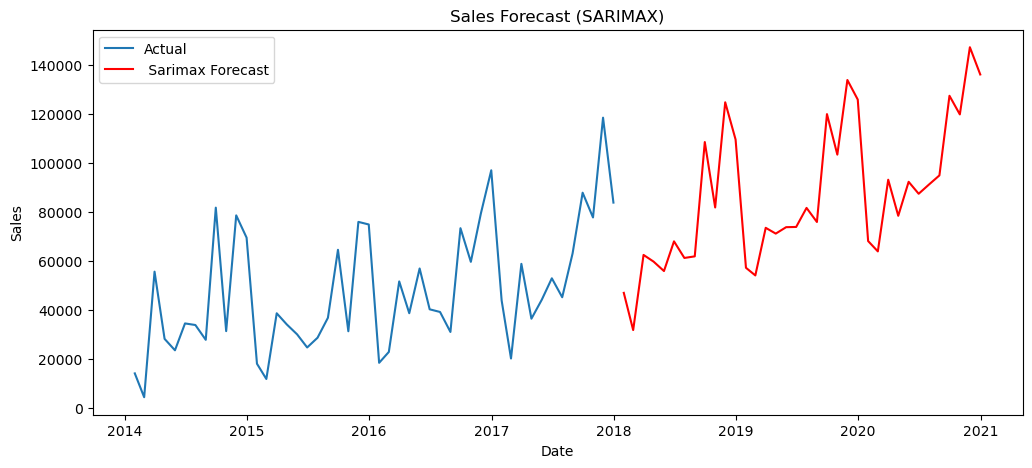

In [12]:
plt.figure(figsize=(12,5))
plt.plot(monthly_sales['Sales'], label='Actual')
plt.plot(sarimax_forecast, color='red', label=' Sarimax Forecast')
plt.title('Sales Forecast (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.savefig('sarimax_forecast_plot.png', bbox_inches='tight')
plt.show()

In [132]:
sarimax_forecast=pd.concat([monthly_sales,sarimax_forecast])

file_name='sarimax_forecast.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(sarimax_forecast,abs_path)

['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\sarimax_forecast.joblib']

## Prophet Model

In [13]:
from prophet import Prophet

prophet_df=monthly_sales.reset_index().rename(columns={'date':'ds','Sales':'y'})

train=prophet_df.iloc[:-6,:]
test=prophet_df.iloc[-6:,:]

pro_model=Prophet()
pro_model.fit(train)

future = pro_model.make_future_dataframe(periods=6, freq='M') 

pro_forecast=pro_model.predict(future)

file_name='forecast_6m.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(pro_forecast,abs_path)

12:32:19 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\CSC\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\forecast_6m.joblib'

In [127]:
file_name='prophet_model.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(pro_model,abs_path)

['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\prophet_model.joblib']

In [14]:
pred=pro_forecast.tail(6)['yhat'].values
actual=test['y'].values

In [109]:
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
mape = np.mean(np.abs((actual - pred) / actual)) * 100

print(f"Prophet Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

prophet_metrics = pd.DataFrame({
    'Model': ['Prophet'],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
})

file_name='prophet_metrics.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(prophet_metrics,abs_path)

Prophet Model Evaluation:
RMSE: 18853.45
MAE : 15164.50
MAPE: 18.07%


['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\prophet_metrics.joblib']

C:\Users\CSC\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


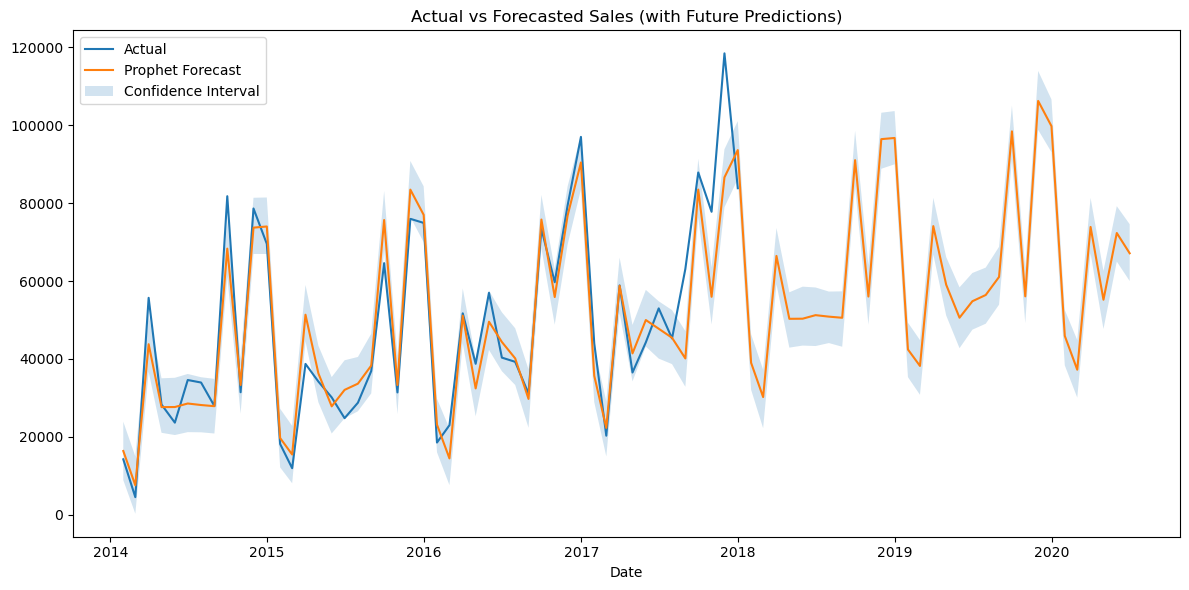

In [15]:
future = pro_model.make_future_dataframe(periods=36, freq='M') 

pro_forecast=pro_model.predict(future)

plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'],prophet_df['y'],label='Actual')
plt.plot(pro_forecast['ds'],pro_forecast['yhat'],label='Prophet Forecast')
plt.fill_between(pro_forecast['ds'],pro_forecast['yhat_lower'],pro_forecast['yhat_upper'],alpha=0.2,label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel=('Sales')
plt.title('Actual vs Forecasted Sales (with Future Predictions)')
plt.legend()
plt.tight_layout()

plt.savefig('prophet_forecast.png', bbox_inches='tight')
plt.show()

In [130]:
file_name='forecast_36m.joblib'
file_path=r'C:\Users\CSC\Documents\Portfolio\Superstore project\Saved models\Time Series'
abs_path=os.path.join(file_path,file_name)

joblib.dump(pro_forecast,abs_path)

['C:\\Users\\CSC\\Documents\\Portfolio\\Superstore project\\Saved models\\Time Series\\forecast_36m.joblib']

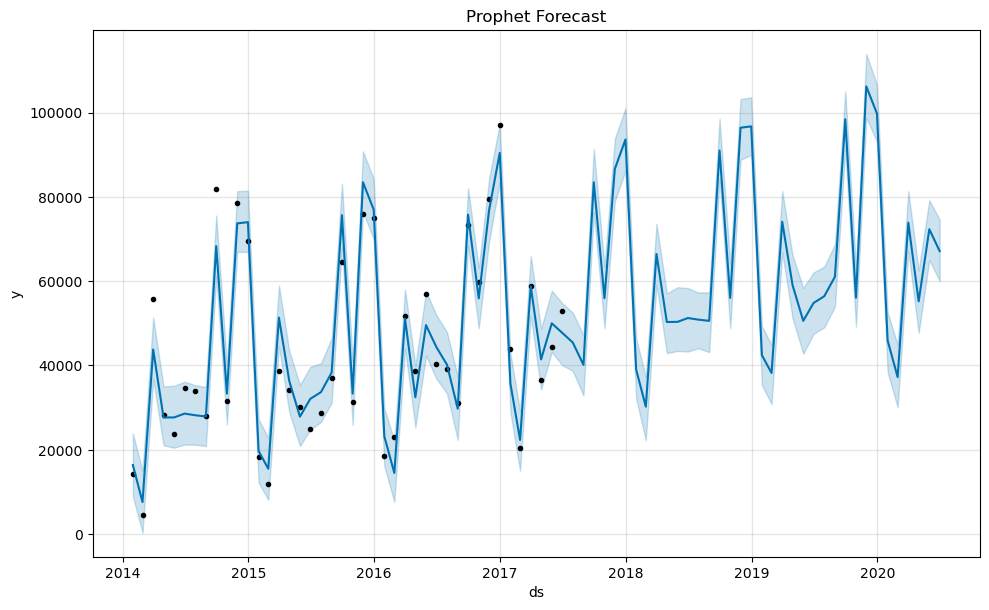

In [18]:
forecast_fig=pro_model.plot(pro_forecast)
plt.title('Prophet Forecast')
plt.savefig('prophet_plot.png',bbox_inches='tight')
plt.show()

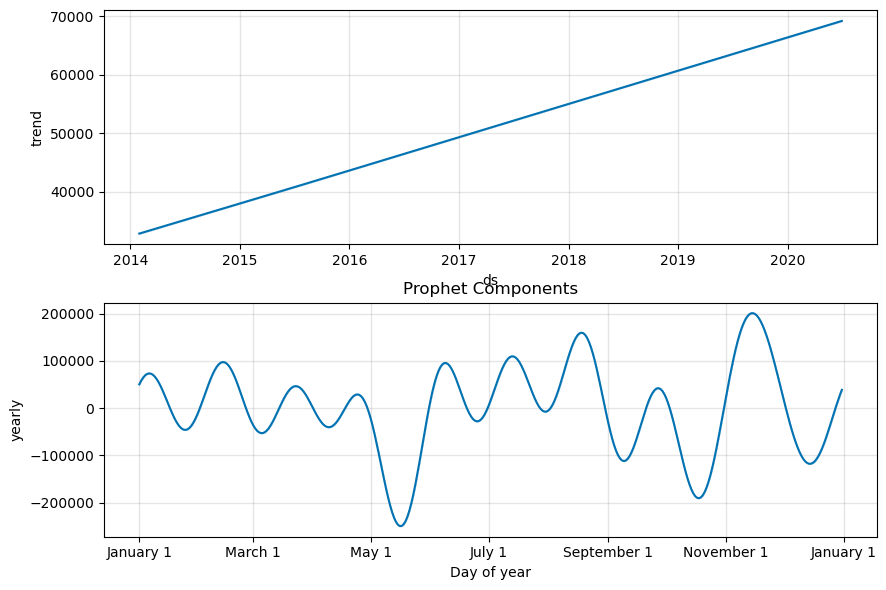

In [20]:
components_fig=pro_model.plot_components(pro_forecast)
plt.title('Prophet Components')
plt.savefig("prophet_components.png", bbox_inches='tight')
plt.show()